In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yfin
import pandas_datareader.data as pdr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV,learning_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay,auc,roc_auc_score,precision_recall_curve,roc_curve,recall_score,precision_score,f1_score
from tensorflow.keras.optimizers import Adam
import re
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
yfin.pdr_override()
pd.set_option('display.max_columns', None)

In [15]:
df_d_lag = pd.read_csv('../data/8-lag-feature-day.csv')
df_d_lag['timestamp'] = pd.to_datetime(df_d_lag['timestamp'])
df_d_lag.set_index('timestamp',inplace=True)

#target variable: change
train = df_d_lag.iloc[:538]
test = df_d_lag.iloc[538:]
train_X_lag = train.drop(columns='target_direction')
train_Y_lag = train['target_direction']
test_X_lag = test.drop(columns='target_direction')
test_Y_lag = test['target_direction']

In [16]:
df_d_lag.head()

,subjectivity,compound,pos_pol,neg_pol,neu_pol,text,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,change,direction,short_mavg,subjectivity (t-1),subjectivity (t-2),compound (t-1),compound (t-2),pos_pol (t-1),pos_pol (t-2),neg_pol (t-1),neg_pol (t-2),neu_pol (t-1),neu_pol (t-2),text (t-1),text (t-2),Open (t-1),Open (t-2),High (t-1),High (t-2),Low (t-1),Low (t-2),Close (t-1),Close (t-2),Volume_(BTC) (t-1),Volume_(BTC) (t-2),Volume_(Currency) (t-1),Volume_(Currency) (t-2),Weighted_Price (t-1),Weighted_Price (t-2),change (t-1),change (t-2),direction (t-1),direction (t-2),short_mavg (t-1),short_mavg (t-2),target_direction
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11,0.317164,0.269069,0.149517,0.042975,0.807562,663,443.84,443.88,443.84,443.88,1.720607,763.713400,443.862797,-5.85,0,440.136667,0.269307,0.285102,0.380652,0.368382,0.169471,0.169491,0.012698,0.020570,0.817844,0.809971,516.0,571.0,449.51,454.71,449.73,454.76,449.51,454.71,449.73,454.76,3.196410,1.401400,1437.288159,637.264186,449.656962,454.733971,-5.03,0.26,0.0,1.0,438.976667,436.063333,1.0
2016-01-12,0.374819,0.265744,0.156485,0.046433,0.797148,586,445.80,445.80,445.80,445.80,3.051522,1360.368557,445.800000,1.92,1,441.665556,0.317164,0.269307,0.269069,0.380652,0.149517,0.169471,0.042975,0.012698,0.807562,0.817844,663.0,516.0,443.84,449.51,443.88,449.73,443.84,449.51,443.88,449.73,1.720607,3.196410,763.713400,1437.288159,443.862797,449.656962,-5.85,-5.03,0.0,0.0,440.136667,438.976667,1.0
2016-01-13,0.348373,0.401209,0.178198,0.009812,0.812005,449,446.14,446.37,446.06,446.06,1.833123,817.804665,446.126401,0.26,1,443.663333,0.374819,0.317164,0.265744,0.269069,0.156485,0.149517,0.046433,0.042975,0.797148,0.807562,586.0,663.0,445.80,443.84,445.80,443.88,445.80,443.84,445.80,443.88,3.051522,1.720607,1360.368557,763.713400,445.800000,443.862797,1.92,-5.85,1.0,0.0,441.665556,440.136667,0.0
2016-01-14,0.328722,0.263915,0.151168,0.046565,0.802337,649,429.82,429.82,429.82,429.82,1.395518,599.821637,429.820000,-16.24,0,443.174444,0.348373,0.374819,0.401209,0.265744,0.178198,0.156485,0.009812,0.046433,0.812005,0.797148,449.0,586.0,446.14,445.80,446.37,445.80,446.06,445.80,446.06,445.80,1.833123,3.051522,817.804665,1360.368557,446.126401,445.800000,0.26,1.92,1.0,1.0,443.663333,441.665556,1.0
2016-01-15,0.294612,0.344127,0.164895,0.023571,0.811553,594,430.95,430.95,430.95,430.95,0.500000,215.475000,430.950000,1.13,1,442.922222,0.328722,0.348373,0.263915,0.401209,0.151168,0.178198,0.046565,0.009812,0.802337,0.812005,649.0,449.0,429.82,446.14,429.82,446.37,429.82,446.06,429.82,446.06,1.395518,1.833123,599.821637,817.804665,429.820000,446.126401,-16.24,0.26,0.0,1.0,443.174444,443.663333,0.0


### Exploratory Data Analysis

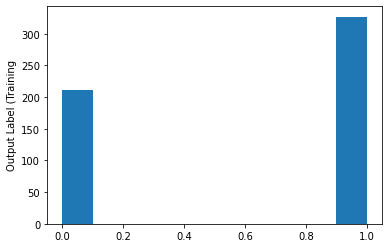

In [43]:
plt.hist(train_Y_lag)
plt.ylabel('Output Label (Training')
plt.show(); #if you predict them as 1, it will have baseline accuracy > 50%

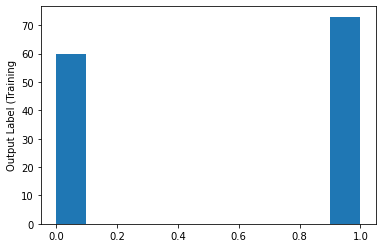

In [44]:
plt.hist(test_Y_lag)
plt.ylabel('Output Label (Training')
plt.show();

### Modeling

In [39]:
#model scoring overview

def scoring_overview(model,title,gridsearch,X_train=train_X_lag,X_test=test_X_lag,y_train=train_Y_lag,y_test=test_Y_lag):
    fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(14,12))
    ax = ax.ravel()
    fig.suptitle(f'{title}',fontsize=30,fontproperties = {'weight':'bold'})

    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #training score and test score display
    ax[0].grid(False)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].annotate('Training Accuracy Score',xy=(0.1,0.8),fontsize=16,va='top',ha='left')
    ax[0].annotate(f'{round(train_score*100,2)}%',xy=(0.5,0.6),fontsize=20,va='top',ha='center',fontweight='bold')
    ax[0].annotate('Testing Accuracy Score',xy=(0.1,0.4),fontsize=16,va='top',ha='left')
    ax[0].annotate(f'{round(test_score*100,2)}%',xy=(0.5,0.2),fontsize=20,va='top',ha='center',fontweight='bold')

    #for all precision, recall, and auc score
    ax[1].grid(False)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].annotate(f'ROC Score: {round(roc*100,2)}%',xy=(0.1,0.7),fontsize=16)
    ax[1].annotate(f'Recall Score: {round(recall*100,2)}%',xy=(0.1,0.5),fontsize=16)
    ax[1].annotate(f'Precision Score: {round(precision*100,2)}%',xy=(0.1,0.3),fontsize=16)
    ax[1].annotate(f'F1 Score: {round(f1*100,2)}%',xy=(0.1,0.1),fontsize=16)

    #plotting confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    plot_confusion_matrix(model, X_test, y_test, display_labels = ['Decrease','Increase'], cmap='Blues', values_format='d',ax=ax[5])
    miss = fp+fn

    #plotting Metrics used 
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    if gridsearch == 'Yes':
        ax[4].grid(False)
        delta_y = 0.9/(len(model.best_params_)+1)
        y = 0.9
        ax[4].annotate('Hyperparameter Tuning',xy=(0.3,1),fontsize=14,fontweight='bold')
        for metric,val in model.best_params_.items():
            y-=delta_y
            a  = re.findall('_([^_]*_[^_]*$)',metric)[0]
            b = re.search('[^_]+',metric)[0]
            ax[4].annotate(
                text= f'{a} metrics for {b} : {val}',
                xy = (0.1,y),
                fontsize = 16,
            )
    #precision-recall curve:
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    classes= np.unique(y_test)
    predicted_prob = model.predict_proba(X_test)
    for i in range(len(classes)):
        precision, recall, thresholds = precision_recall_curve(
                    y_test_array[:,i], predicted_prob[:,i])
        ax[3].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  auc(recall, precision))
              )
    ax[3].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
    ax[3].legend(loc="best")
    ax[3].grid(True)

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
        ax[2].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                auc(fpr, tpr))
                )
    ax[2].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[2].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver Operating Characteristic (ROC)")
    ax[2].legend(loc="lower right")
    ax[2].grid(True)

    for s in ['top','right','bottom','left']:
        ax[0].spines[s].set_visible(False)
        ax[1].spines[s].set_visible(False)
        ax[4].spines[s].set_visible(False)
def gs_model(estimator,param,X,y):
    gs_model = RandomizedSearchCV(
    estimator = estimator,
    param_distributions = param,
    cv = 5,
    n_jobs = -1,
    return_train_score = True,
    verbose=1,
    scoring = 'f1',
)
    gs_model.fit(X,y)
    return gs_model


### Linear Regression

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


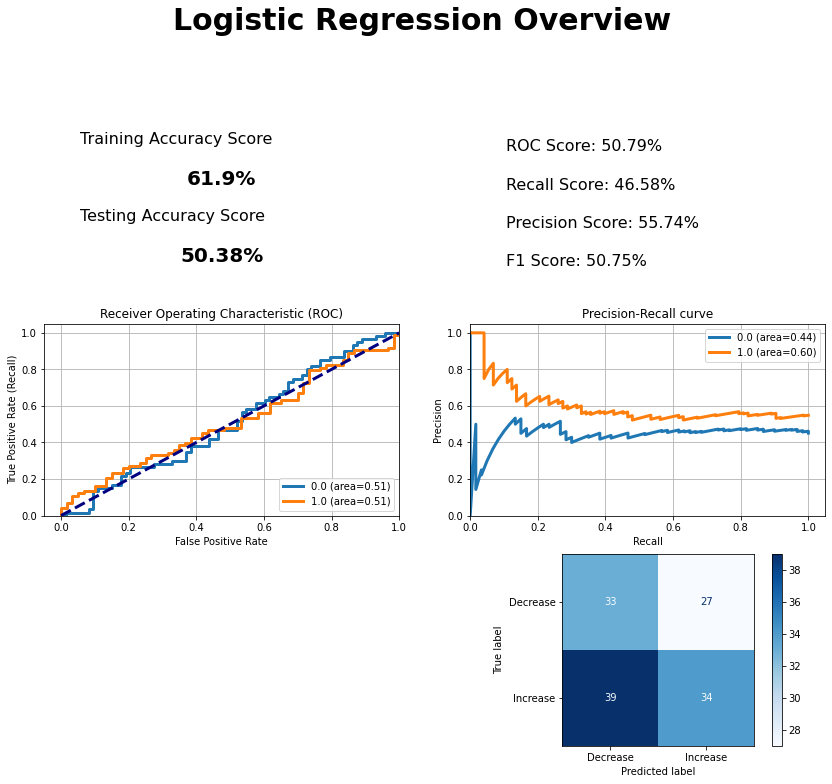

In [34]:
model_1_pipe = Pipeline([
        ('mm',MinMaxScaler()),
        ('lr_cv',LogisticRegression(max_iter=100000,random_state=42))
    ])

model_1_pipe.fit(train_X_lag,train_Y_lag);
scoring_overview(model=model_1_pipe,title='Logistic Regression Overview', gridsearch='No')

### XGBoost

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[22:48:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[22:48:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[22:48:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[22:48:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "max_depth", "min_child_weight" } are not used.

[22:48:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/lear

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


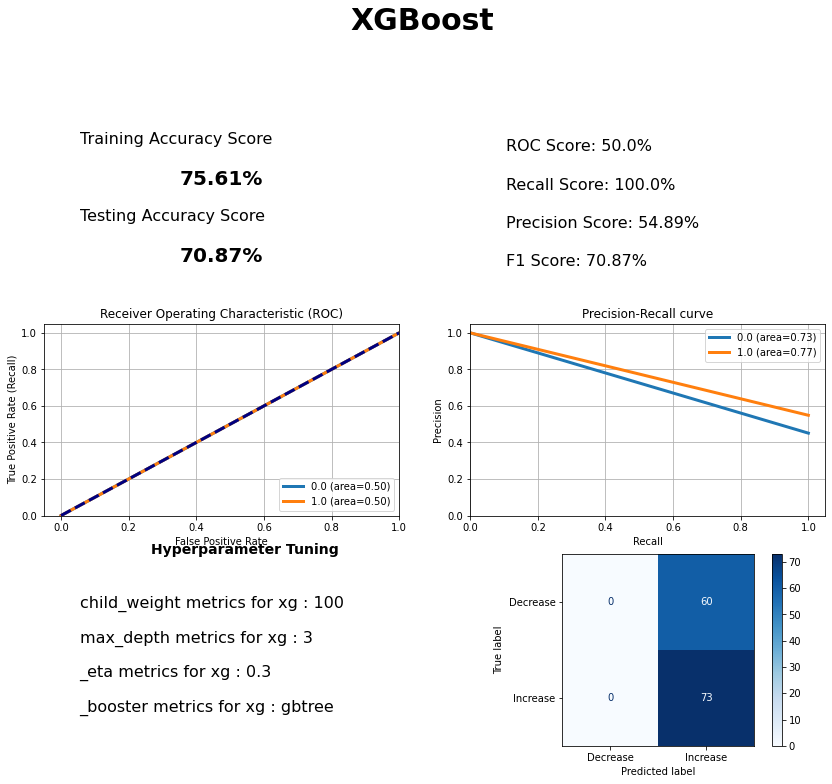

In [40]:

model_2_pipe = Pipeline([
    ('mm',MinMaxScaler()),
    ('xg', XGBClassifier(random_state=42))
    ])

pipe_2_params = {
    'xg__booster': ['gbtree','gblinear','dart'],
    'xg__eta': [0.01,0.1,0.3,0.5,0.7],
    'xg__min_child_weight':[1,10,50,100],
    'xg__max_depth': [3,6,9],
}
#gs_nb_cv = gs_model(model_3_pipe,pipe_3_params,train_X,train_Y)
gs_model_2 =gs_model(model_2_pipe,pipe_2_params,train_X_lag,train_Y_lag)
scoring_overview(gs_model_2,title ='XGBoost',gridsearch='Yes')

### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


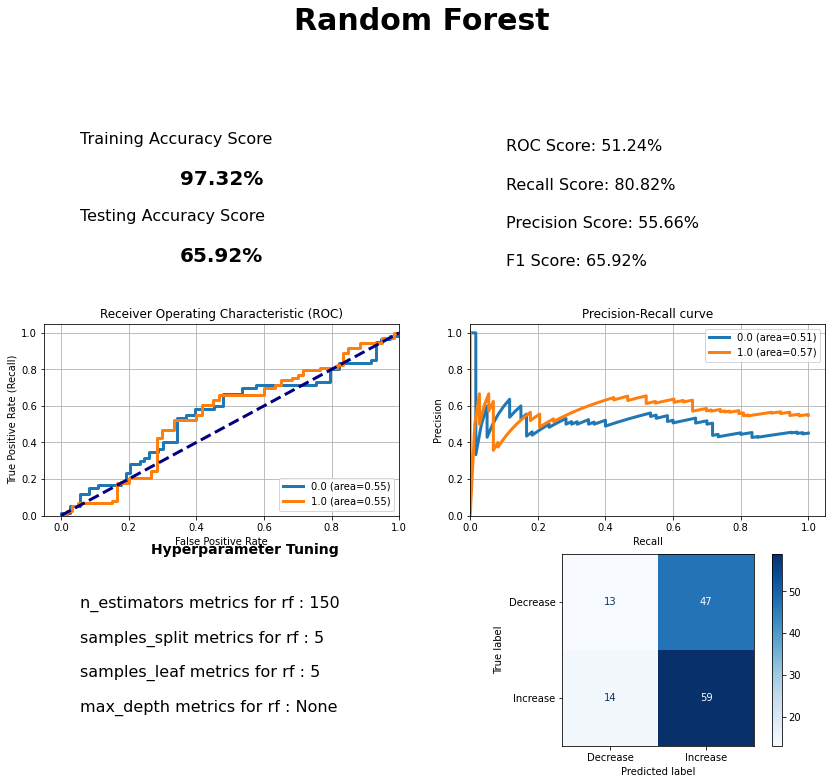

In [42]:
model_3_pipe = Pipeline([
    ('mm',MinMaxScaler()),
    ('rf', RandomForestClassifier(random_state=42))
    ])

pipe_3_params = {
    'rf__n_estimators': [50,100,125,150],
    'rf__min_samples_split': [2,5,9],
    'rf__min_samples_leaf':[1,2,5],
    'rf__max_depth': [10,25,50,75,100,None],
}
#gs_nb_cv = gs_model(model_3_pipe,pipe_3_params,train_X,train_Y)
gs_model_3 =gs_model(model_3_pipe,pipe_3_params,train_X_lag,train_Y_lag)
scoring_overview(gs_model_3,title ='Random Forest',gridsearch='Yes')

### Feedforward Neural Networks 

In [68]:
y_train = np.asarray(train_Y_lag).astype('float32').reshape((-1,1))
y_test = np.asarray(test_Y_lag).astype('float32').reshape((-1,1))

In [79]:
model = Sequential()

# In order to "align" our neurons in a vertical array, we
# add a "Flatten" layer. This will be required before adding
# subsequent Dense layers. We need to specify the input shape.
model.add(Flatten(input_shape=(48,1)))

# Let's create a fully-connected, feed-forward neural net with:
# - A 128-node hidden layer.
# - A 32-node hidden layer.
# - The appropriate output layer (multiclass classification")
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 48)                0         
                                                                 
 dense_21 (Dense)            (None, 128)               6272      
                                                                 
 dense_22 (Dense)            (None, 32)                4128      
                                                                 
 dense_23 (Dense)            (None, 10)                330       
                                                                 
Total params: 10,730
Trainable params: 10,730
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Compile model.
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit model on training data.
history = model.fit(train_X_lag,
                    y_train, 
                    #batch_size=256,
                    validation_data=(test_X_lag, y_test),
                    epochs=10,
                    verbose=1)

Epoch 1/10


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/losses.py", line 2176, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py", line 5680, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 10) vs (None, 1)).
